In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm

tqdm.pandas()

In [3]:
spectra_df = pd.read_csv("data/msn_pos_100AGC_60000Res.csv", sep=",")
spectra_df.INTENSITIES = spectra_df.INTENSITIES.apply(lambda v: json.loads(v))
spectra_df.MZS = spectra_df.MZS.apply(lambda v: json.loads(v))
spectra_df.PRECURSOR_LIST = spectra_df.PRECURSOR_LIST.apply(lambda v: json.loads(v))
spectra_df["FILENAME_NO_EXT"] = spectra_df["FILENAME"].apply(lambda v: v.split(".")[0])
spectra_df["lib_plate_well"] = spectra_df["FILENAME_NO_EXT"].apply(lambda v: "pluskal_{}".format(v.split("pluskal_")[1]))
spectra_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585730 entries, 0 to 585729
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   FILENAME         585730 non-null  object 
 1   SCAN_NUMBER      585730 non-null  int64  
 2   TREE_ID          585730 non-null  int64  
 3   MS_LEVEL         585730 non-null  int64  
 4   PRECURSOR_MZ     585730 non-null  float64
 5   PRECURSOR_MS2    585730 non-null  float64
 6   PRECURSOR_LIST   585730 non-null  object 
 7   N_SIGNALS        585730 non-null  int64  
 8   MAX_MSN          585730 non-null  int64  
 9   N_PREC           585730 non-null  int64  
 10  N_PREC_MS3       585730 non-null  int64  
 11  N_PREC_MS4       585730 non-null  int64  
 12  N_PREC_MS5       585730 non-null  int64  
 13  N_PREC_MS6       585730 non-null  int64  
 14  N_SPEC           585730 non-null  int64  
 15  N_MS2            585730 non-null  int64  
 16  N_MS3            585730 non-null  int6

In [7]:
def get_intensities(df, min_ms_level, max_ms_level=None):
    if max_ms_level is None or max_ms_level<=min_ms_level:
        filtered = df[df["MS_LEVEL"]==min_ms_level]
    else:
        filtered = df[df["MS_LEVEL"].between(min_ms_level,max_ms_level, 'both')]
    return np.concatenate(filtered.INTENSITIES.values)

def get_mzs(df: pd.DataFrame, min_ms_level: int, max_ms_level=None):
    if max_ms_level is None or max_ms_level<=min_ms_level:
        filtered = df[df["MS_LEVEL"]==min_ms_level]
    else:
        filtered = df[df["MS_LEVEL"].between(min_ms_level,max_ms_level, 'both')]
    return np.concatenate(filtered.MZS.values)

def get_datapoints(df, min_ms_level, max_ms_level=None):
    if max_ms_level is None or max_ms_level<=min_ms_level:
        filtered = df[df["MS_LEVEL"]==min_ms_level]
    else:
        filtered = df[df["MS_LEVEL"].between(min_ms_level,max_ms_level, 'both')]

    return np.concatenate(filtered.MZS.values), np.concatenate(filtered.INTENSITIES.values)

In [5]:
def save_fig(file_name):
    plt.savefig("figures/{}.png".format(file_name), dpi=300)
    plt.savefig("figures/{}.pdf".format(file_name))
    plt.savefig("figures/{}.svg".format(file_name))

In [8]:
spectra_df["MIN_INTENSITY"] = spectra_df["INTENSITIES"].apply(lambda intensities: min(intensities))
spectra_df["N_SIGNALS_FILTERED"] = [sum(value > min_intensity*3 for value in intensities) for intensities, min_intensity in zip(spectra_df["INTENSITIES"], spectra_df["MIN_INTENSITY"])]
spectra_df

,FILENAME,SCAN_NUMBER,TREE_ID,MS_LEVEL,PRECURSOR_MZ,PRECURSOR_MS2,PRECURSOR_LIST,N_SIGNALS,MAX_MSN,N_PREC,...,N_MS3,N_MS4,N_MS5,N_MS6,MZS,INTENSITIES,FILENAME_NO_EXT,lib_plate_well,MIN_INTENSITY,N_SIGNALS_FILTERED
0,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,746,1,2,865.32129,865.32129,[865.32129],12,2,0,...,0,0,0,0,"[45.03254, 48.39606, 52.50083, 53.62123, 58.92...","[3466.0, 4002.0, 3536.0, 3962.0, 3740.0, 3893....",20220613_100AGC_60000Res_pluskal_mce_1D1_A4,pluskal_mce_1D1_A4,3336.0,1
1,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,747,1,2,865.32129,865.32129,[865.32129],8,2,0,...,0,0,0,0,"[47.2327, 64.2806, 74.34347, 96.09348, 102.853...","[4738.0, 3716.0, 3872.0, 3777.0, 5243.0, 3881....",20220613_100AGC_60000Res_pluskal_mce_1D1_A4,pluskal_mce_1D1_A4,3716.0,1
2,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,748,1,2,865.32129,865.32129,[865.32129],13,2,0,...,0,0,0,0,"[44.00995, 53.85102, 59.93157, 115.56989, 121....","[3362.0, 3461.0, 3574.0, 3991.0, 3887.0, 12300...",20220613_100AGC_60000Res_pluskal_mce_1D1_A4,pluskal_mce_1D1_A4,3362.0,1
3,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,569,2,2,687.46313,687.46313,[687.46313],15,4,3,...,3,6,0,0,"[69.13714, 79.20178, 81.5592, 84.74924, 115.83...","[5271.0, 4743.0, 6009.0, 5277.0, 4836.0, 4450....",20220613_100AGC_60000Res_pluskal_mce_1D1_A4,pluskal_mce_1D1_A4,4450.0,2
4,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,570,2,2,687.46313,687.46313,[687.46313],50,4,3,...,3,6,0,0,"[43.26883, 51.17478, 54.20185, 60.08066, 72.07...","[4866.0, 4455.0, 4722.0, 86910.0, 9452.0, 3367...",20220613_100AGC_60000Res_pluskal_mce_1D1_A4,pluskal_mce_1D1_A4,4455.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585725,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,138,20324,3,95.04887,155.06998,"[155.06998, 95.04887]",32,3,3,...,9,0,0,0,"[41.03863, 44.25225, 49.88511, 50.01513, 51.02...","[1879.0, 461.0, 532.0, 573.0, 659.0, 8420.0, 5...",20220613_100AGC_60000Res_pluskal_mce_1D3_L15,pluskal_mce_1D3_L15,403.0,5
585726,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,139,20324,3,95.04887,155.06998,"[155.06998, 95.04887]",18,3,3,...,9,0,0,0,"[41.03866, 43.1236, 47.78329, 50.01509, 51.022...","[530.0, 475.0, 497.0, 1762.0, 2422.0, 9184.0, ...",20220613_100AGC_60000Res_pluskal_mce_1D3_L15,pluskal_mce_1D3_L15,432.0,3
585727,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,140,20324,3,90.94743,155.06998,"[155.06998, 90.94743]",20,3,3,...,9,0,0,0,"[42.92147, 51.59386, 54.9977, 55.35921, 56.239...","[602.0, 622.0, 478.0, 527.0, 511.0, 446.0, 465...",20220613_100AGC_60000Res_pluskal_mce_1D3_L15,pluskal_mce_1D3_L15,434.0,2
585728,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,141,20324,3,90.94743,155.06998,"[155.06998, 90.94743]",23,3,3,...,9,0,0,0,"[42.04765, 42.12828, 46.46843, 47.03485, 47.13...","[431.0, 480.0, 406.0, 443.0, 455.0, 602.0, 533...",20220613_100AGC_60000Res_pluskal_mce_1D3_L15,pluskal_mce_1D3_L15,406.0,2


## Add compound matches to spectra_df

In [9]:
lib_id = "mce"
filename = "data/lib_formatted_{}.csv".format(lib_id)
lib_df = pd.read_csv(filename, sep="\t")
lib_df["all_ions"] = lib_df.apply(lambda row: [row["mz_h_smiles"], row["mz_na_smiles"]], axis=1)
lib_df.head()

,RackCode,Plate Location,VialCode,Cat. No.,Product Name,Synonyms,CAS No.,M.Wt,Target,Saltdata,...,lib_plate_well,exact_mass,mz_h,mz_na,cleaned_smiles,exact_mass_smiles,mz_h_smiles,mz_na_smiles,mass_matches,all_ions
0,HYCPK16574,A2,NaN,HY-15338,TG003,NaN,719277-26-6,249.33,CDK,Free Base,...,pluskal_mce_1D1_A1,249.082350,250.089626,272.071571,CCN1/C(=C/C(C)=O)Sc2ccc(OC)cc21,249.082350,250.089626,272.071570,True,"[250.08962618223, 272.071570432]"
1,HYCPK16574,A3,NaN,HY-15440B,Fostemsavir Tris,BMS-663068 (Tris),864953-39-9,704.62,HIV,Tris,...,pluskal_mce_1D1_A1,704.231941,705.239218,727.221162,COc1cnc(-n2cnc(C)n2)c2c1c(C(=O)C(=O)N1CCN(C(=O...,583.158047,584.165324,606.147268,False,"[584.16532388423, 606.147268134]"
2,HYCPK16574,A4,NaN,HY-114315,NQO1 substrate,NaN,2304503-05-5,268.18,Others,Free Base,...,pluskal_mce_1D1_A1,268.019667,269.026943,291.008888,N#Cc1nc2c(nc1C#N)-c1cc(F)c(F)cc1C2=O,268.019667,269.026944,291.008888,True,"[269.02694358623, 291.00888783600004]"
3,HYCPK16574,A5,NaN,HY-15357,ALK inhibitor 1,NaN,761436-81-1,562.48,ALK; FAK,Free Base,...,pluskal_mce_1D1_A1,561.115772,562.123048,584.104992,CNS(=O)(=O)c1ccccc1Nc1nc(Nc2ccc(N3CCN(C)CC3)cc...,561.115771,562.123047,584.104992,True,"[562.1230473182302, 584.1049915680002]"
4,HYCPK16574,A6,NaN,HY-15880,CCT007093,NaN,176957-55-4,272.39,Apoptosis; Autophagy; Phosphatase,Free Base,...,pluskal_mce_1D1_A1,272.032957,273.040234,295.022178,O=C1/C(=C/c2cccs2)CC/C1=C\c1cccs1,272.032957,273.040233,295.022178,True,"[273.04023346622995, 295.022177716]"


In [10]:
def find_match(spectrum_row, lib_df):
    if spectrum_row["MS_LEVEL"] > 2:
        return []

    precursor_mz = spectrum_row["PRECURSOR_MS2"]
    filtered_df = lib_df[(lib_df["lib_plate_well"] == spectrum_row["lib_plate_well"]) & lib_df["mz_h_smiles"].between(precursor_mz-mz_tolerance, precursor_mz+mz_tolerance)]

    return filtered_df.index.tolist()

def propagate_match(spectrum_row, spectra_df):
    tree_id = spectrum_row["TREE_ID"]
    filtered_df = spectra_df[(spectra_df["TREE_ID"] == tree_id) & (spectra_df["MS_LEVEL"] == 2)]
    return filtered_df["LIB_INDEX"].values[0]

In [11]:
mz_tolerance = 0.05

# find index in metadata lib_df
#filtered_spectra = spectra_df.loc[spectra_df["MS_LEVEL"] == 2]
spectra_df["LIB_INDEX"] = spectra_df.progress_apply(lambda row: find_match(row, lib_df), axis=1)
# propagate index to MSn
spectra_df["LIB_INDEX"] = spectra_df.progress_apply(lambda row: propagate_match(row, spectra_df), axis=1)
# transfer metadata columns
spectra_df["PRODUCT_NAME"] = spectra_df["LIB_INDEX"].progress_apply(lambda index: lib_df.at[index[0], "Product Name"] if len(index) >= 1 else "")
spectra_df["SMILES"] = spectra_df["LIB_INDEX"].progress_apply(lambda index: lib_df.at[index[0], "Smiles"] if len(index) >= 1 else "")
spectra_df["EXACT_MASS"] = spectra_df["LIB_INDEX"].progress_apply(lambda index: lib_df.at[index[0], "exact_mass_smiles"] if len(index) >= 1 else np.nan)
spectra_df["ANNOTATED"] = spectra_df["LIB_INDEX"].progress_apply(lambda index: len(index) >= 1)
spectra_df["N_MATCHES"] = spectra_df["LIB_INDEX"].progress_apply(lambda index: len(index))

100%|██████████| 585730/585730 [00:00<00:00, 1026994.78it/s]


In [12]:
spectra_df.to_csv("data/spectra_match_{}_100AGC_60000.csv".format(lib_id), sep="\t", index=False)

spectra_df.to_pickle("data/spectra_match_{}_100AGC_60000.pkl".format(lib_id))

In [13]:
spectra_df

,FILENAME,SCAN_NUMBER,TREE_ID,MS_LEVEL,PRECURSOR_MZ,PRECURSOR_MS2,PRECURSOR_LIST,N_SIGNALS,MAX_MSN,N_PREC,...,FILENAME_NO_EXT,lib_plate_well,MIN_INTENSITY,N_SIGNALS_FILTERED,LIB_INDEX,PRODUCT_NAME,SMILES,EXACT_MASS,ANNOTATED,N_MATCHES
0,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,746,1,2,865.32129,865.32129,[865.32129],12,2,0,...,20220613_100AGC_60000Res_pluskal_mce_1D1_A4,pluskal_mce_1D1_A4,3336.0,1,[],,,NaN,False,0
1,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,747,1,2,865.32129,865.32129,[865.32129],8,2,0,...,20220613_100AGC_60000Res_pluskal_mce_1D1_A4,pluskal_mce_1D1_A4,3716.0,1,[],,,NaN,False,0
2,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,748,1,2,865.32129,865.32129,[865.32129],13,2,0,...,20220613_100AGC_60000Res_pluskal_mce_1D1_A4,pluskal_mce_1D1_A4,3362.0,1,[],,,NaN,False,0
3,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,569,2,2,687.46313,687.46313,[687.46313],15,4,3,...,20220613_100AGC_60000Res_pluskal_mce_1D1_A4,pluskal_mce_1D1_A4,4450.0,2,[],,,NaN,False,0
4,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,570,2,2,687.46313,687.46313,[687.46313],50,4,3,...,20220613_100AGC_60000Res_pluskal_mce_1D1_A4,pluskal_mce_1D1_A4,4455.0,16,[],,,NaN,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585725,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,138,20324,3,95.04887,155.06998,"[155.06998, 95.04887]",32,3,3,...,20220613_100AGC_60000Res_pluskal_mce_1D3_L15,pluskal_mce_1D3_L15,403.0,5,[],,,NaN,False,0
585726,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,139,20324,3,95.04887,155.06998,"[155.06998, 95.04887]",18,3,3,...,20220613_100AGC_60000Res_pluskal_mce_1D3_L15,pluskal_mce_1D3_L15,432.0,3,[],,,NaN,False,0
585727,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,140,20324,3,90.94743,155.06998,"[155.06998, 90.94743]",20,3,3,...,20220613_100AGC_60000Res_pluskal_mce_1D3_L15,pluskal_mce_1D3_L15,434.0,2,[],,,NaN,False,0
585728,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,141,20324,3,90.94743,155.06998,"[155.06998, 90.94743]",23,3,3,...,20220613_100AGC_60000Res_pluskal_mce_1D3_L15,pluskal_mce_1D3_L15,406.0,2,[],,,NaN,False,0


In [2]:
# spectra_df = pd.read_csv('data/spectra_match_mce_100AGC_60000.csv', sep="\t")

spectra_df = pd.read_pickle('data/spectra_match_mce_100AGC_60000.pkl')

In [16]:
spectra_df

,FILENAME,SCAN_NUMBER,TREE_ID,MS_LEVEL,PRECURSOR_MZ,PRECURSOR_MS2,PRECURSOR_LIST,N_SIGNALS,MAX_MSN,N_PREC,...,lib_plate_well,MIN_INTENSITY,N_SIGNALS_FILTERED,LIB_INDEX,PRODUCT_NAME,SMILES,EXACT_MASS,ANNOTATED,N_MATCHES,N_DP_SIMPLE
0,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,746,1,2,865.32129,865.32129,[865.32129],12,2,0,...,pluskal_mce_1D1_A4,3336.0,1,[],,,NaN,False,0,1
1,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,747,1,2,865.32129,865.32129,[865.32129],8,2,0,...,pluskal_mce_1D1_A4,3716.0,1,[],,,NaN,False,0,1
2,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,748,1,2,865.32129,865.32129,[865.32129],13,2,0,...,pluskal_mce_1D1_A4,3362.0,1,[],,,NaN,False,0,1
3,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,569,2,2,687.46313,687.46313,[687.46313],15,4,3,...,pluskal_mce_1D1_A4,4450.0,2,[],,,NaN,False,0,2
4,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,570,2,2,687.46313,687.46313,[687.46313],50,4,3,...,pluskal_mce_1D1_A4,4455.0,16,[],,,NaN,False,0,11-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585725,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,138,20324,3,95.04887,155.06998,"[155.06998, 95.04887]",32,3,3,...,pluskal_mce_1D3_L15,403.0,5,[],,,NaN,False,0,5-6
585726,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,139,20324,3,95.04887,155.06998,"[155.06998, 95.04887]",18,3,3,...,pluskal_mce_1D3_L15,432.0,3,[],,,NaN,False,0,3
585727,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,140,20324,3,90.94743,155.06998,"[155.06998, 90.94743]",20,3,3,...,pluskal_mce_1D3_L15,434.0,2,[],,,NaN,False,0,2
585728,20220613_100AGC_60000Res_pluskal_mce_1D3_L15.mzML,141,20324,3,90.94743,155.06998,"[155.06998, 90.94743]",23,3,3,...,pluskal_mce_1D3_L15,406.0,2,[],,,NaN,False,0,2


In [15]:
# spectra_df.INTENSITIES = spectra_df.INTENSITIES.apply(lambda v: json.loads(v))
# spectra_df.MZS = spectra_df.MZS.apply(lambda v: json.loads(v))
# spectra_df.PRECURSOR_LIST = spectra_df.PRECURSOR_LIST.apply(lambda v: json.loads(v))
# spectra_df.LIB_INDEX = spectra_df.LIB_INDEX.apply(lambda v: json.loads(v))

# put number of data points into meaningful bins
evaluation_bins = [0, 0.5, 1, 2, 3, 4, 6, 10, 20, 50, 100, np.inf]
group_names =     ["0", '1', '2', '3', '4', '5-6', '7-10', '11-20', '21-50', '51-100', '>100']


spectra_df["N_DP_SIMPLE"] = pd.cut(spectra_df['N_SIGNALS_FILTERED'], bins=evaluation_bins,
                                labels=group_names,
                                  include_lowest=True, right=True)


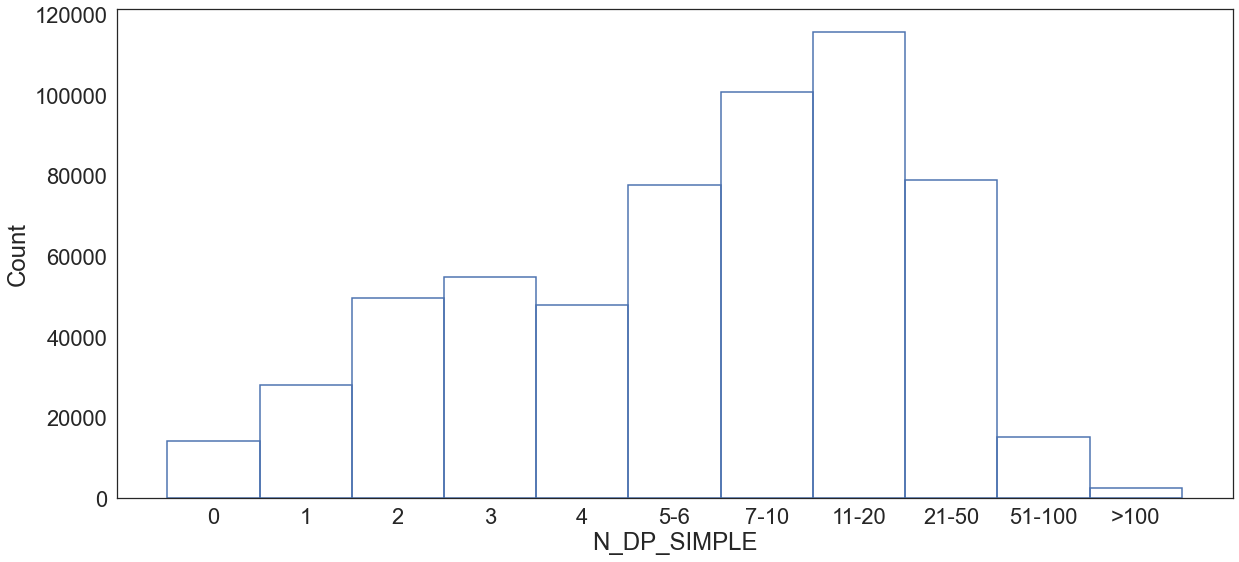

In [16]:
sns.set_theme(font_scale=2, style="white")

plt.figure(figsize=(20, 9))
ax = sns.histplot(data=spectra_df, x="N_DP_SIMPLE", fill=False)
save_fig("MCE_n_signals_filtered_categories_all_spectra_pp")

## Filter for unique library matches, for each method, and each precursor mz

In [17]:
# find all with match, keep best spectrum (highest N of signals) for each precursor of each compound

matched_df = spectra_df[spectra_df["N_MATCHES"] >= 1]
matched_df["FIRST_LIB_INDEX"] = [lib_ids[0] if len(lib_ids)>0 else "" for lib_ids in matched_df['LIB_INDEX']]
matched_df["PRECURSOR_MZ_LOW_RES"] = [round(mz, 2) for mz in matched_df['PRECURSOR_MZ']]
matched_df = matched_df.sort_values('N_SIGNALS_FILTERED', ascending=False).drop_duplicates(['FIRST_LIB_INDEX','PRECURSOR_MZ_LOW_RES'], keep="first").sort_index()

C:\Users\BrungsC\AppData\Local\Temp\ipykernel_8632\3742024375.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_df["FIRST_LIB_INDEX"] = [lib_ids[0] if len(lib_ids)>0 else "" for lib_ids in matched_df['LIB_INDEX']]
C:\Users\BrungsC\AppData\Local\Temp\ipykernel_8632\3742024375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_df["PRECURSOR_MZ_LOW_RES"] = [round(mz, 2) for mz in matched_df['PRECURSOR_MZ']]


In [18]:
matched_df.to_csv("data/onlycompound_match_{}_100AGC_60000.csv".format(lib_id), sep="\t", index=False)

matched_df.to_pickle("data/onlycompound_match_{}_100AGC_60000.pkl".format(lib_id))

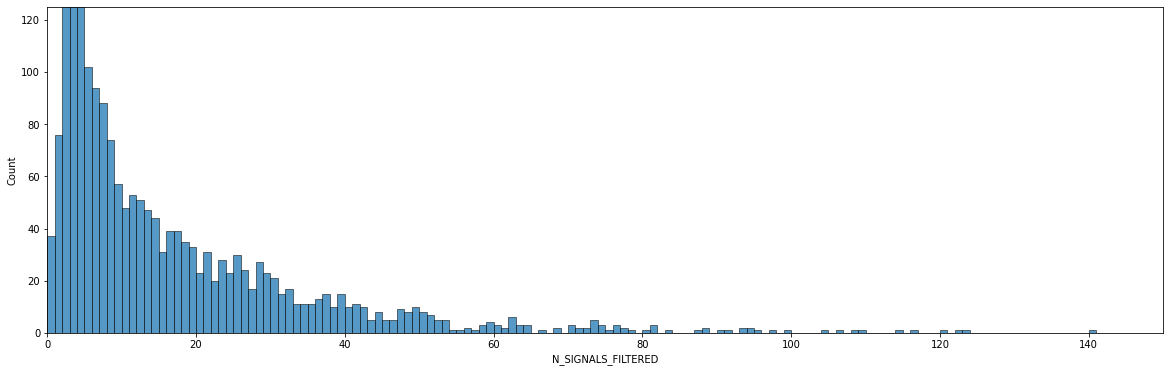

In [10]:
plt.figure(figsize=(20, 6))
ax = sns.histplot(data=matched_df, x="N_SIGNALS_FILTERED", binwidth=1)
ax.set_xlim(0,150)
ax.set_ylim(0,125)
save_fig("histo_signals_gr_3xmin_intensity")

In [22]:
matched_df = pd.read_pickle('data/onlycompound_match_mce_100AGC_60000.pkl')

In [23]:
matched_df

,FILENAME,SCAN_NUMBER,TREE_ID,MS_LEVEL,PRECURSOR_MZ,PRECURSOR_MS2,PRECURSOR_LIST,N_SIGNALS,MAX_MSN,N_PREC,...,N_SIGNALS_FILTERED,LIB_INDEX,PRODUCT_NAME,SMILES,EXACT_MASS,ANNOTATED,N_MATCHES,N_DP_SIMPLE,FIRST_LIB_INDEX,PRECURSOR_MZ_LOW_RES
17,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,468,3,2,508.19467,508.19467,[508.19467],74,4,13,...,32,[34],SPHINX31,O=C(NC1=C(N2CCN(CC3=CC=CC=N3)CC2)C=CC(C(F)(F)F...,507.188210,True,1,21-50,34,508.19
19,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,471,3,3,172.03918,508.19467,"[508.19467, 172.03918]",36,4,13,...,13,[34],SPHINX31,O=C(NC1=C(N2CCN(CC3=CC=CC=N3)CC2)C=CC(C(F)(F)F...,507.188210,True,1,11-20,34,172.04
21,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,503,3,4,145.02585,508.19467,"[508.19467, 172.03918, 145.02585]",29,4,13,...,2,[34],SPHINX31,O=C(NC1=C(N2CCN(CC3=CC=CC=N3)CC2)C=CC(C(F)(F)F...,507.188210,True,1,2,34,145.03
26,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,502,3,4,116.04933,508.19467,"[508.19467, 172.03918, 116.04933]",41,4,13,...,11,[34],SPHINX31,O=C(NC1=C(N2CCN(CC3=CC=CC=N3)CC2)C=CC(C(F)(F)F...,507.188210,True,1,11-20,34,116.05
29,20220613_100AGC_60000Res_pluskal_mce_1D1_A4.mzML,475,3,3,135.09142,508.19467,"[508.19467, 135.09142]",64,4,13,...,24,[34],SPHINX31,O=C(NC1=C(N2CCN(CC3=CC=CC=N3)CC2)C=CC(C(F)(F)F...,507.188210,True,1,21-50,34,135.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573176,20220613_100AGC_60000Res_pluskal_mce_1D3_K17.mzML,208,19804,3,109.07590,126.10272,"[126.10272, 109.0759]",83,4,6,...,47,[10241],1-Methylhistamine (dihydrochloride),NCCC1=CN(C)C=N1.[H]Cl.[H]Cl,125.095297,True,1,21-50,10241,109.08
573182,20220613_100AGC_60000Res_pluskal_mce_1D3_K17.mzML,223,19804,4,94.05254,126.10272,"[126.10272, 109.0759, 94.05254]",29,4,6,...,6,[10241],1-Methylhistamine (dihydrochloride),NCCC1=CN(C)C=N1.[H]Cl.[H]Cl,125.095297,True,1,5-6,10241,94.05
573187,20220613_100AGC_60000Res_pluskal_mce_1D3_K17.mzML,210,19804,3,97.07588,126.10272,"[126.10272, 97.07588]",27,4,6,...,9,[10241],1-Methylhistamine (dihydrochloride),NCCC1=CN(C)C=N1.[H]Cl.[H]Cl,125.095297,True,1,7-10,10241,97.08
573193,20220613_100AGC_60000Res_pluskal_mce_1D3_K17.mzML,216,19804,3,96.06809,126.10272,"[126.10272, 96.06809]",24,4,6,...,7,[10241],1-Methylhistamine (dihydrochloride),NCCC1=CN(C)C=N1.[H]Cl.[H]Cl,125.095297,True,1,7-10,10241,96.07


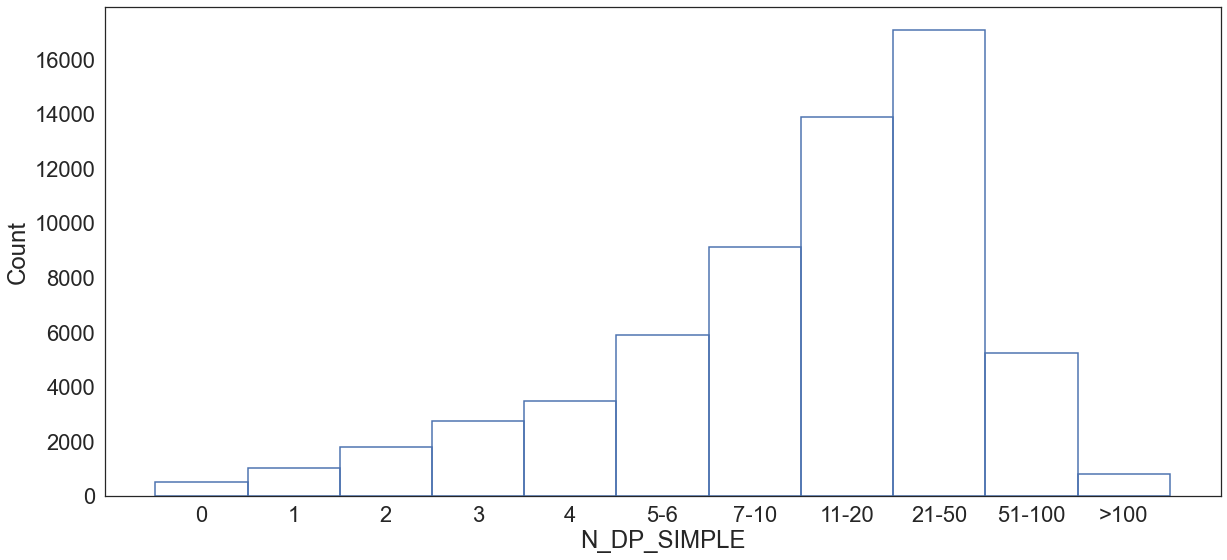

In [19]:
plt.figure(figsize=(20, 9))
ax = sns.histplot(data=matched_df, x="N_DP_SIMPLE", fill=False)
save_fig("MCE_n_signals_filtered_categories_pp")

In [20]:
best_df = matched_df.sort_values('FILENAME', ascending=True).drop_duplicates(['FIRST_LIB_INDEX', "FILENAME"], keep="first")

In [21]:
best_df

,FILENAME,SCAN_NUMBER,TREE_ID,MS_LEVEL,PRECURSOR_MZ,PRECURSOR_MS2,PRECURSOR_LIST,N_SIGNALS,MAX_MSN,N_PREC,...,N_SIGNALS_FILTERED,LIB_INDEX,PRODUCT_NAME,SMILES,EXACT_MASS,ANNOTATED,N_MATCHES,N_DP_SIMPLE,FIRST_LIB_INDEX,PRECURSOR_MZ_LOW_RES
8328,20220613_100AGC_60000Res_pluskal_mce_1D1_A11.mzML,563,244,3,290.07364,406.08197,"[406.08197, 290.07364]",88,5,19,...,30,[107],BPN14770,O=C(O)CC1=CC=C(CC2=CC(C3=CC=CC(Cl)=C3)=NC(C(F)...,405.074341,True,1,21-50,107,290.07
8293,20220613_100AGC_60000Res_pluskal_mce_1D1_A11.mzML,355,243,4,128.06194,416.18661,"[416.18661, 165.07024, 128.06194]",60,5,20,...,29,[102],ML228,C1(C2=NC=CC=C2)=NC(NCC3=CC=C(C4=CC=CC=C4)C=C3)...,415.179696,True,1,21-50,102,128.06
8184,20220613_100AGC_60000Res_pluskal_mce_1D1_A11.mzML,188,241,4,102.04626,471.26407,"[471.26407, 112.11178, 102.04626]",37,5,14,...,14,[108],VUF11207 (fumarate),C/C(CN(C(C1=CC(OC)=C(C(OC)=C1)OC)=O)CCC2N(CCC2...,470.258086,True,1,11-20,108,102.05
8190,20220613_100AGC_60000Res_pluskal_mce_1D1_A11.mzML,193,242,2,431.25458,431.25458,[431.25458],90,5,15,...,49,[103],EHop-016,CCN1C2=C(C3=C1C=CC=C3)C=C(NC4=NC(NCCCN5CCOCC5)...,430.248110,True,1,21-50,103,431.25
8423,20220613_100AGC_60000Res_pluskal_mce_1D1_A11.mzML,471,247,3,311.96619,388.00925,"[388.00925, 311.96619]",42,5,13,...,5,[104],ERK5-IN-2,FC1=CC=CC(Br)=C1C(C2=CNC(C(NC3=CC=CN=C3)=O)=C2)=O,387.001867,True,1,5-6,104,311.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569676,20220613_100AGC_60000Res_pluskal_mce_1D3_K8.mzML,249,19645,4,103.05417,292.22769,"[292.22769, 133.06471, 103.05417]",25,4,9,...,4,[10155],Penbutolol (sulfate),O[C@@H](CNC(C)(C)C)COC1=CC=CC=C1C2CCCC2.[0.5H2...,291.219829,True,1,4,10155,103.05
569559,20220613_100AGC_60000Res_pluskal_mce_1D3_K8.mzML,513,19639,4,100.07562,481.23053,"[481.23053, 128.1068, 100.07562]",26,4,2,...,8,[10152],Copanlisib (dihydrochloride),O=C(C1=CN=C(N)N=C1)NC2=NC3=C(OC)C(OCCCN4CCOCC4...,480.223351,True,1,7-10,10152,100.08
569846,20220613_100AGC_60000Res_pluskal_mce_1D3_K8.mzML,260,19650,3,95.08535,172.13341,"[172.13341, 95.08535]",41,4,10,...,17,[10158],Gabapentin (hydrochloride),O=C(O)CC1(CN)CCCCC1.[H]Cl,171.125929,True,1,11-20,10158,95.09
570109,20220613_100AGC_60000Res_pluskal_mce_1D3_K9.mzML,245,19663,4,102.04629,247.18060,"[247.1806, 129.06995, 102.04629]",43,4,10,...,13,[10165],Milnacipran ((1S-cis) hydrochloride),O=C([C@]1(C2=CC=CC=C2)[C@H](CN)C1)N(CC)CC.[H]Cl,246.173213,True,1,11-20,10165,102.05


In [24]:
best_df["FILENAME"].value_counts()

20220613_100AGC_60000Res_pluskal_mce_1D1_J13.mzML    10
20220613_100AGC_60000Res_pluskal_mce_1D2_B10.mzML    10
20220613_100AGC_60000Res_pluskal_mce_1D1_B7.mzML     10
20220613_100AGC_60000Res_pluskal_mce_1D2_D24.mzML    10
20220613_100AGC_60000Res_pluskal_mce_1D2_A13.mzML    10
                                                     ..
20220613_100AGC_60000Res_pluskal_mce_1D3_I11.mzML     1
20220613_100AGC_60000Res_pluskal_mce_1D3_I12.mzML     1
20220613_100AGC_60000Res_pluskal_mce_1D3_K13.mzML     1
20220613_100AGC_60000Res_pluskal_mce_1D3_I13.mzML     1
20220613_100AGC_60000Res_pluskal_mce_1D2_C20.mzML     1
Name: FILENAME, Length: 1015, dtype: int64

In [25]:
matched_df['PRODUCT_NAME'].nunique()

6535

In [26]:
spectra_df['PRODUCT_NAME'].nunique()


6536

## Analyze

In [ ]:
levels = [2,3,4,5]
fig, axs = plt.subplots(len(levels), sharex="all", figsize=(15,15))

fig.suptitle('Vertically stacked subplots')

for i, level in enumerate(levels):
    ax = sns.histplot(data=spectra_df[spectra_df["MS_LEVEL"]==level], ax=axs[i], x="PRECURSOR_MZ", binwidth=0.1)
    ax.set(xlabel='precursor m/z', ylabel='MS{} counts'.format(level))
    ax.set_xlim(70,1000)
    #ax.set_ylim(0, 40)

In [ ]:
plt.figure(figsize=(20, 6))
mzs, intensities = get_datapoints(spectra_df, 3, 6)

df = pd.DataFrame({"mz": mzs, "intensity": intensities})
ax = sns.histplot(data=df[df["intensity"]>1500], x="mz", binwidth=0.1)
ax.set_xlim(40,800)
# ax.set_xlim(50,500)

In [ ]:
plt.figure(figsize=(20, 6))
intensities = get_intensities(spectra_df, 3)
df = pd.DataFrame({"INTENSITIES": intensities})
count_intensities_MS3 = sns.histplot(data=df[df["INTENSITIES"]<20000], x="INTENSITIES", binwidth=100)
count_intensities_MS3.set_xlim(0,20000)
save_fig("histo_intensity_ms3")

In [ ]:
plt.figure(figsize=(20, 6))
intensities = get_intensities(spectra_df, 2)
df = pd.DataFrame({"INTENSITIES": intensities})
count_intensities_MS2 = sns.histplot(data=df[df["INTENSITIES"]<20000], x="INTENSITIES", binwidth=50)
count_intensities_MS2.set_xlim(0,20000)
save_fig("histo_intensities_MS2")

In [ ]:
plt.figure(figsize=(20, 6))
intensities = get_intensities(spectra_df, 4)
df = pd.DataFrame({"INTENSITIES": intensities})
count_intensities_MS2 = sns.histplot(data=df[df["INTENSITIES"]<20000], x="INTENSITIES", binwidth=50)
count_intensities_MS2.set_xlim(0,20000)
save_fig("histo_intensities_MS4")

In [ ]:
Precursor_against_mslevel = sns.violinplot(data=spectra_df, x="MS_LEVEL", y="PRECURSOR_MZ", cut=0)
save_fig("Violin_Precursor_against_mslevel")

In [ ]:
Signals_against_MSlevel = sns.violinplot(data=spectra_df, x="MS_LEVEL", y="N_SIGNALS", cut=0)
save_fig("Violin_Signals_against_MSlevel")

In [ ]:
sns.histplot(data=spectra_df, x="PRECURSOR_MZ", hue="MS_LEVEL", multiple="stack")
save_fig("histo_MSlevel")

In [ ]:
intensities  = get_intensities(spectra_df, 2)
df = pd.DataFrame({"INTENSITIES": intensities})
df[df["INTENSITIES"]>10000]